In [1]:
import os
import pandas as pd
import sys

In [2]:
src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
sys.path.append(src_path)
import preprocessing
import model

In [3]:
df_merged = preprocessing.pre_processing()

c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\src\preprocessing.py:171: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["PACKAGE_DENSITY"].fillna(mean_package_density, inplace=True)
c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\src\preprocessing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [4]:
mean_Data = pd.read_excel("../data/mean_processing_time.xlsx")

c:\Users\92335\Desktop\Studies\semester3\data_science\Project\Data\Data_Science_Project_Group_5\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: Ridge
MSE: 1398.6726066161775
MAE: 30.976600195317985
R²: 0.05431354420400669


Model: Lasso
MSE: 1402.9968850006928
MAE: 31.141992666502134
R²: 0.05138976384255323


Model: Decision Tree
MSE: 417.22289483477226
MAE: 9.225740317207297
R²: 0.7179025035402615


Model: Random Forest
MSE: 427.3988573013769
MAE: 10.441151941821555
R²: 0.711022215877634


Model: Gradient Boosting
MSE: 1279.7082819347302
MAE: 29.299436786563653
R²: 0.1347490585924248


Model: SVR
MSE: 1561.304887396016
MAE: 27.85501183087415
R²: -0.055647246106166115


Model: MLP
MSE: 1350.9350309288054
MAE: 30.103986268575515
R²: 0.08659041768142695




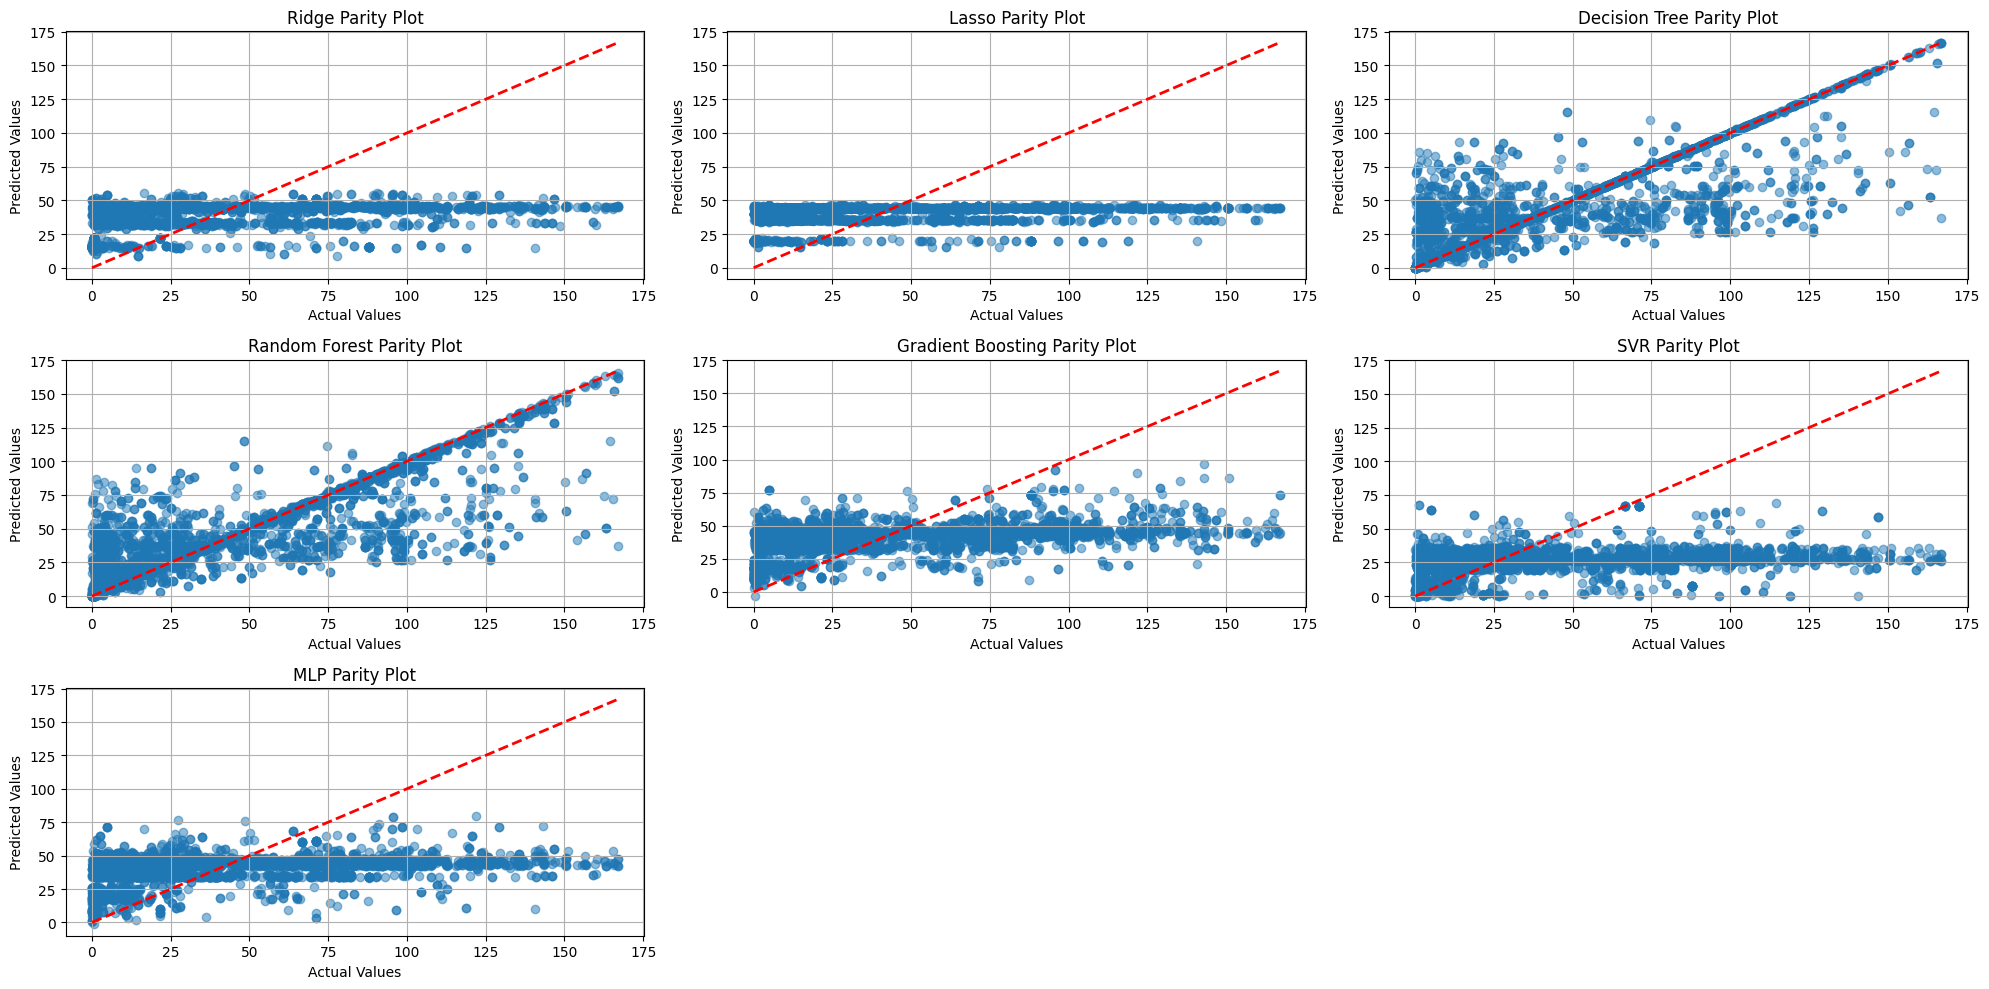

--------- best model from these is Decision Tree --------
Model: Ridge
MSE: 1398.6726066161775
MAE: 30.976600195317985
R²: 0.05431354420400669


Model: Lasso
MSE: 1402.9968850006928
MAE: 31.141992666502134
R²: 0.05138976384255323


Model: Decision Tree
MSE: 417.22289483477226
MAE: 9.225740317207299
R²: 0.7179025035402616


Model: Random Forest
MSE: 427.3988573013769
MAE: 10.441151941821555
R²: 0.711022215877634


Model: Gradient Boosting
MSE: 1279.7082819347302
MAE: 29.299436786563653
R²: 0.1347490585924248


Model: SVR
MSE: 1561.304887396016
MAE: 27.85501183087415
R²: -0.055647246106166115


Model: MLP
MSE: 1350.9350309288054
MAE: 30.103986268575515
R²: 0.08659041768142695




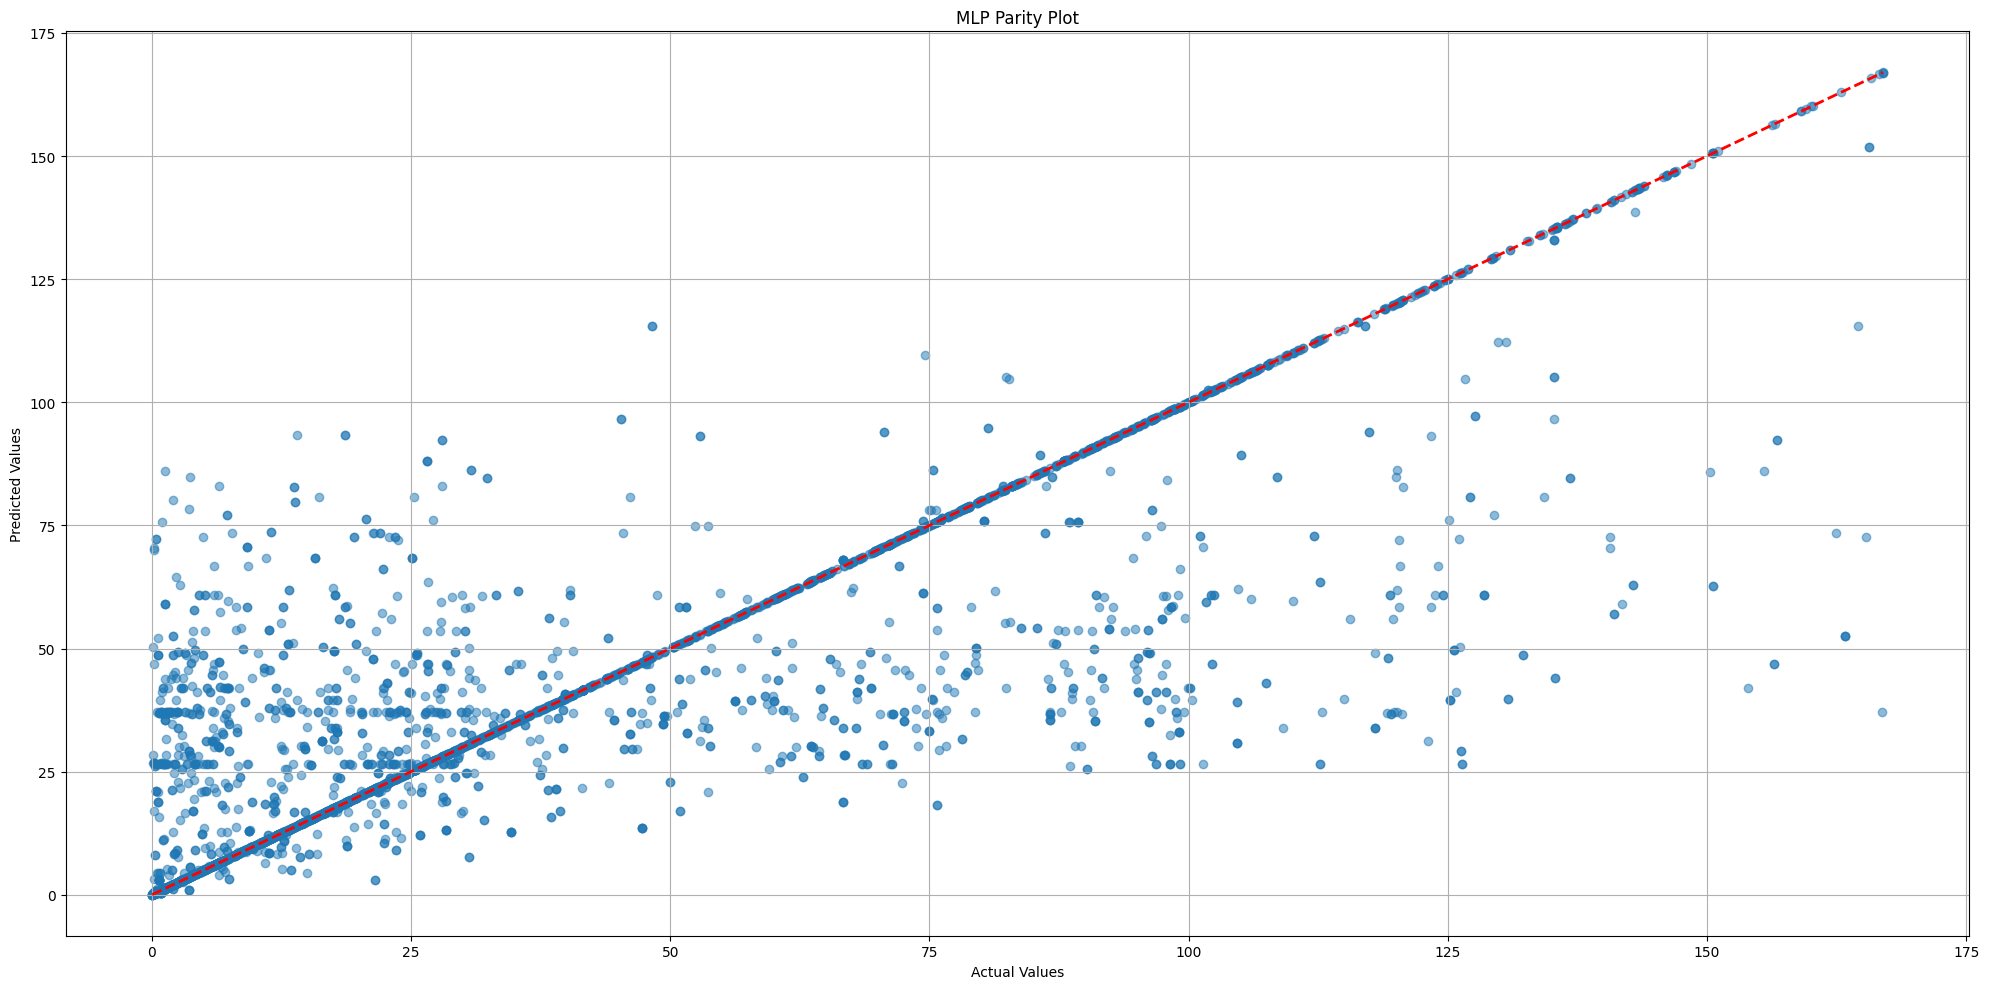

In [5]:
final_results = model.model_results(df_merged, mean_Data)

In [6]:
final_results

,SPECIAL_TRIP,COUNTRY,PRIORITY,PACKAGE_TYPE,PACKAGE_DENSITY,predictions,actual
0,0,7,1,1,112.044818,133.609553,146.325180
1,0,7,3,1,293.333333,69.383236,69.383236
2,0,7,3,1,372.727273,93.211569,93.211569
3,0,7,1,3,212.962963,62.167638,62.167638
4,1,7,1,1,66.666667,62.798892,71.227125
...,...,...,...,...,...,...,...
4346,0,7,1,1,216.666667,113.850005,155.254903
4347,0,6,1,1,80.645161,85.171291,85.171291
4348,0,7,1,1,61.176471,101.518474,88.991569
4349,0,7,3,1,229.166667,71.472403,71.472403
